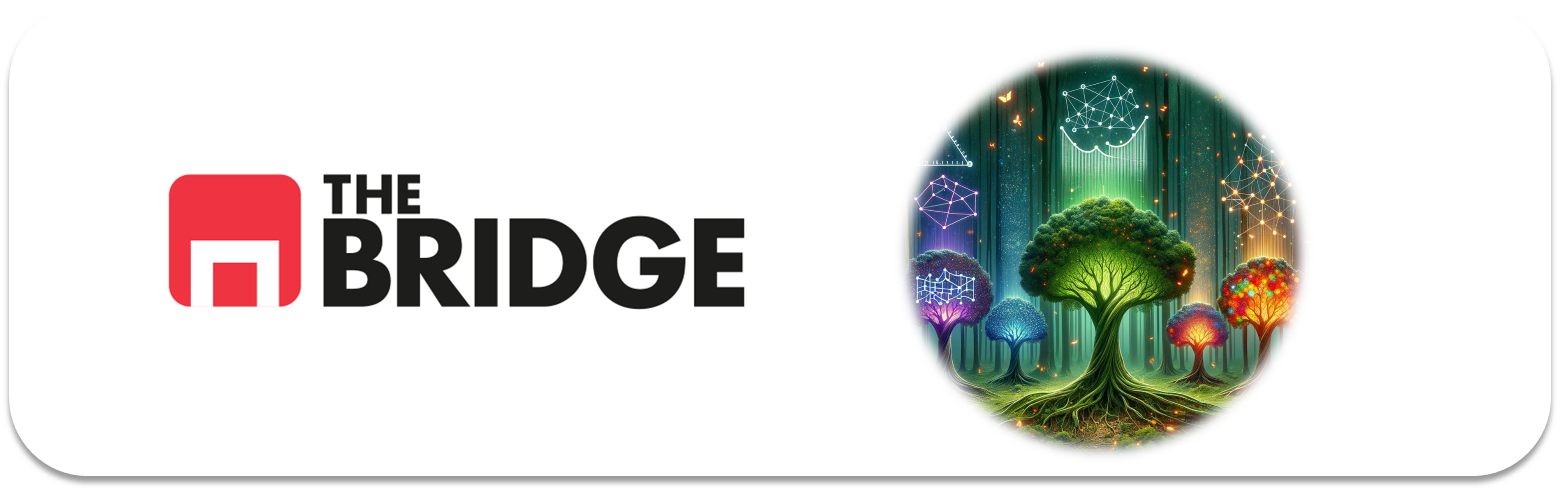

## PRACTICA OBLIGATORIA: **Ensamblado de modelos, bagging, boosting, random forest y gbts**

* La práctica obligatoria de esta unidad consiste en un único ejercicio de obtención del mejor modelo para la resolución de un problema de clasificación sobre diabetes en la india. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import bootcampviztools as bt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

### Descripción del dataset

El dataset de los Pima Indians Diabetes contiene datos de un grupo de mujeres de al menos 21 años de edad de ascendencia india Pima que viven cerca de Phoenix, Arizona, EE. UU. Las características del dataset incluyen varios predictores médicos y un objetivo que indica si la paciente desarrolló diabetes dentro de cinco años.

### Características del Dataset

Las variables incluidas en el dataset son:

1. **Número de Embarazos**: Cantidad de veces embarazada.
2. **Concentración de Glucosa en Plasma**: Concentración de glucosa en plasma a 2 horas en una prueba de tolerancia oral a la glucosa.
3. **Presión Arterial Diastólica**: Presión arterial diastólica (mm Hg).
4. **Grosor del Pliegue Cutáneo del Tríceps**: Grosor del pliegue cutáneo del tríceps (mm).
5. **Insulina en Suero**: Insulina en suero a 2 horas (mu U/ml).
6. **Índice de Masa Corporal**: Peso en kg/(altura en m)^2.
7. **Función del Pedigree de Diabetes**: Una función que representa la predisposición genética a la diabetes.
8. **Edad**: Edad en años.
9. **Variable Objetivo**: Indica si la paciente desarrolló diabetes (1) o no (0).

### Carga de datos

El dataset lo puedes encontrar en la siguiente url y a continuación se proporciona una lista de nombres sugeridos para las columnas:


### Enunciado

Construye el mejor modelo que puedas para predecir a partir de los datos de entrada si una mujer de la tribu Pima desarrollará diabetes. Para ello obtén al menoss tres modelos a partir de tecnologías de bagging y boosting (al menos uno de cada), compáralos sin utilizar el test y selecciona uno de ellos como el mejor (justificándolo). Termina el ejercicio probando el modelo seleccionado y con sus hiperparámetros optimizados contra un dataset de test que deberás haber reservado con anterioridad.

--------------------------

In [2]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"

names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']

In [3]:
df_diabetes = pd.read_csv(url)
df_diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767 entries, 0 to 766
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   6       767 non-null    int64  
 1   148     767 non-null    int64  
 2   72      767 non-null    int64  
 3   35      767 non-null    int64  
 4   0       767 non-null    int64  
 5   33.6    767 non-null    float64
 6   0.627   767 non-null    float64
 7   50      767 non-null    int64  
 8   1       767 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Renombrando las variables (columnas)

In [4]:
columnas = [columna for columna in df_diabetes.columns]
dict_map = {columnas[i]: names[i] for i in range(len(columnas))}

df_diabetes.rename(columns=dict_map, inplace=True)
df_diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767 entries, 0 to 766
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   preg    767 non-null    int64  
 1   plas    767 non-null    int64  
 2   pres    767 non-null    int64  
 3   skin    767 non-null    int64  
 4   test    767 non-null    int64  
 5   mass    767 non-null    float64
 6   pedi    767 non-null    float64
 7   age     767 non-null    int64  
 8   class   767 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Buscando duplicadas

In [5]:
df_diabetes.duplicated().sum()

0

Mirando la cardinalidad

In [6]:
def calcular_cardinalidad(df):
    cardinalidad = {}
    for columna in df.columns:
        cardinalidad[columna] = len(df[columna].unique()) / len(df) * 100
    return pd.DataFrame(cardinalidad.items(), columns=["Columna", "Cardinalidad (%)"])

cardinalidad = calcular_cardinalidad(df_diabetes)
print(cardinalidad)

  Columna  Cardinalidad (%)
0    preg          2.216428
1    plas         17.731421
2    pres          6.127771
3    skin          6.649283
4    test         24.250326
5    mass         32.333768
6    pedi         67.275098
7     age          6.779661
8   class          0.260756


Definiendo target y dividiendo train_set y test_set

In [7]:
target = 'class'

In [8]:
train_set, test_set = train_test_split(df_diabetes, test_size= 0.2, random_state= 42)

Aunque todas las columnas tienen sus valores representados numéricamente, el análisis de la descripción de las columnas y la cardinalidad me lleva a considerar como numéricas continuas solo ["plas", "test", "mass", "pedi"], mientras que todas las demás se consideran categóricas.

In [9]:
features_num = ["plas", "test", "mass", "pedi"]
features_cat = ["preg", "pres", "skin", "age"]

Mirando el balanceo de la variable target

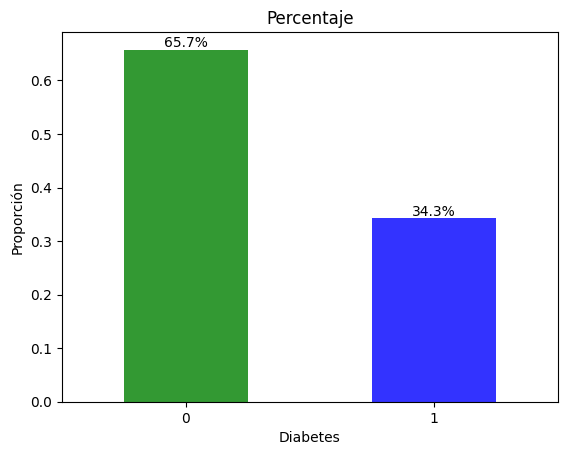

In [10]:
ax = train_set["class"].value_counts(normalize=True).plot(
    kind="bar", color=["green", "blue"], alpha=0.8
)

for p in ax.patches:
    percentage = f"{p.get_height() * 100:.1f}%"
    ax.annotate(
        percentage,
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center",
        va="bottom",
        fontsize=10,
    )

plt.xlabel("Diabetes")
plt.ylabel("Proporción")
plt.title("Percentaje")
plt.xticks(rotation=0)
plt.show()

No posee un desbalanceo muy grande, por lo que continuaremos así

## Mini EDA

Variables CATEGÓRICAS

c:\Users\lucas\anaconda3\envs\GPU-TensorFlow\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


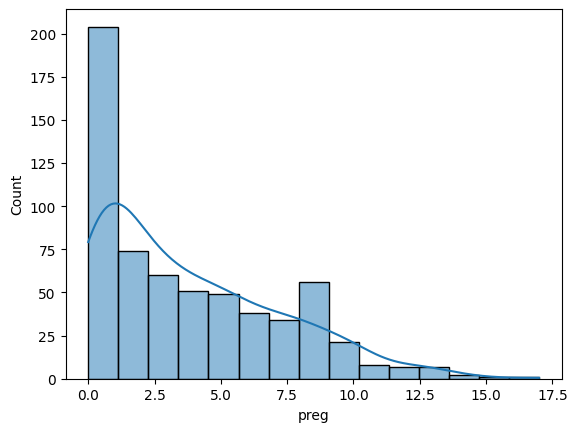

In [11]:
# preg
sns.histplot(train_set['preg'], kde=True)
plt.show()

In [12]:
# Creando rango de valores

bins_preg = [0, 1, 2, 5, 7, 10, np.inf] 
labels_preg = ["0-1", "1-2", "2-5", "5-7", "7-10", "10+"]

train_set['preg'] = pd.cut(train_set['preg'], bins=bins_preg, labels=labels_preg, right=False)
train_set.sample(1)

,preg,plas,pres,skin,test,mass,pedi,age,class
92,2-5,134,72,0,0,23.8,0.277,60,1


In [ ]:
# Siempre comparar la distribución en la variable target (distribución preg en 0 contra preg en 1, por ejemplo)

c:\Users\lucas\Documents\Cursos\The_Bridge\BOOTCAMP\Online_env\ONLINE_DS_THEBRIDGE_BOOTCAMP\04_Machine_Learning\Sprint_11\Unidad_02_Boosting_y_Bagging\Practica_Obligatoria\bootcampviztools.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_data = df.groupby([cat_col1, cat_col2]).size().reset_index(name='count')


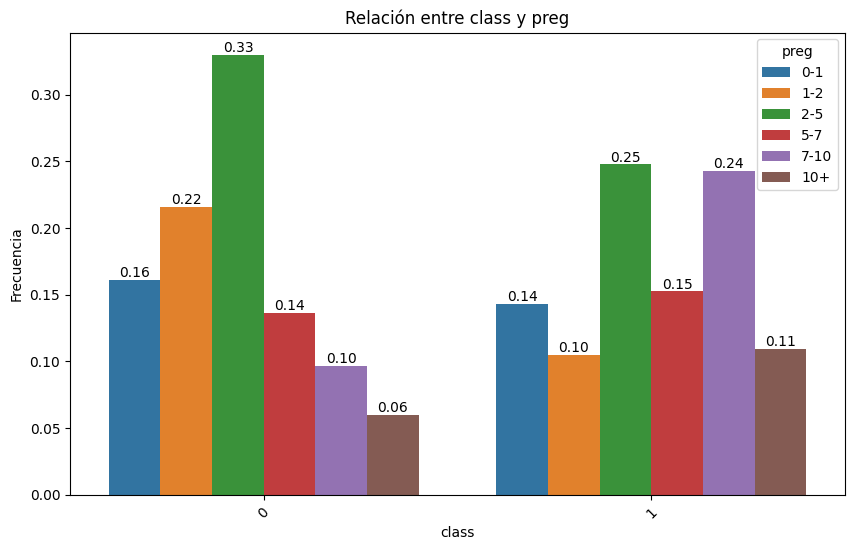

In [13]:
bt.plot_categorical_relationship_fin(train_set, target,"preg", show_values= True, relative_freq= True)

La incidencia de cada categoría parece ser diferente para el target, de tal manera que la columna será considerada relevante y se mantendrá para el modelo.

c:\Users\lucas\anaconda3\envs\GPU-TensorFlow\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


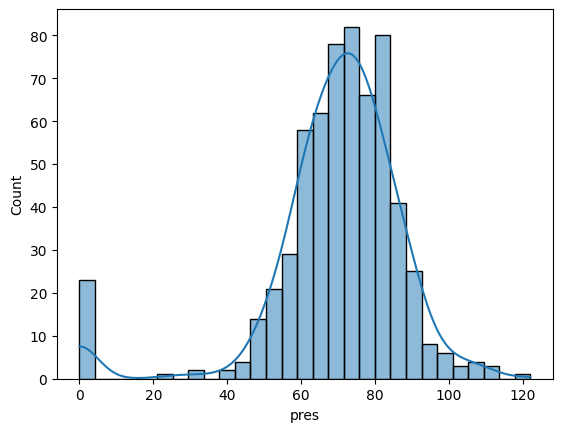

In [14]:
#pres
sns.histplot(train_set['pres'], kde=True)
plt.show()

In [15]:
bins_pres = [0, 20, 50, 60, 70, 80, 90, np.inf] 
labels_pres = ["0-20", "20-50", "50-60", "60-70", "70-80", "80-90", "90+"]

train_set['pres'] = pd.cut(train_set['pres'], bins=bins_pres, labels=labels_pres, right=False)
train_set.sample()

,preg,plas,pres,skin,test,mass,pedi,age,class
477,7-10,126,70-80,38,75,25.9,0.162,39,0


c:\Users\lucas\Documents\Cursos\The_Bridge\BOOTCAMP\Online_env\ONLINE_DS_THEBRIDGE_BOOTCAMP\04_Machine_Learning\Sprint_11\Unidad_02_Boosting_y_Bagging\Practica_Obligatoria\bootcampviztools.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_data = df.groupby([cat_col1, cat_col2]).size().reset_index(name='count')


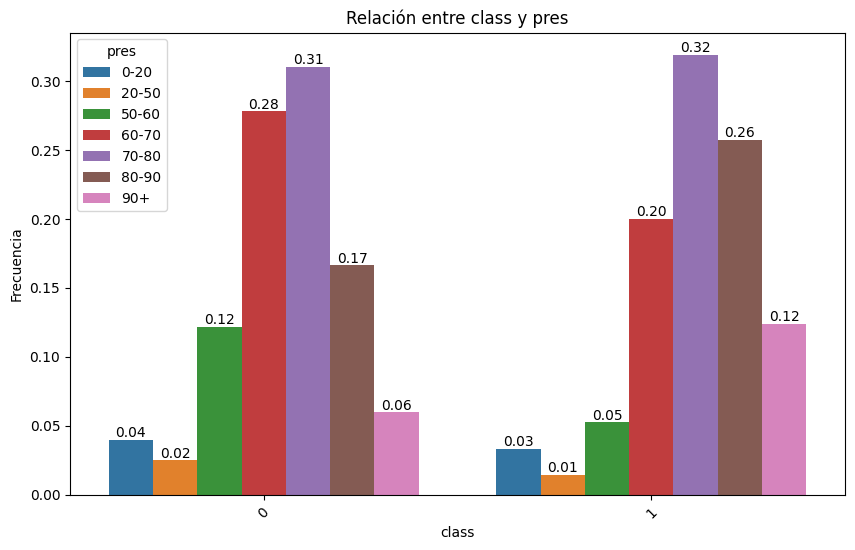

In [16]:
bt.plot_categorical_relationship_fin(train_set, target,"pres", show_values= True, relative_freq= True)

La incidencia de cada categoría parece ser diferente para el target, de tal manera que la columna será considerada relevante y se mantendrá para el modelo.

c:\Users\lucas\anaconda3\envs\GPU-TensorFlow\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


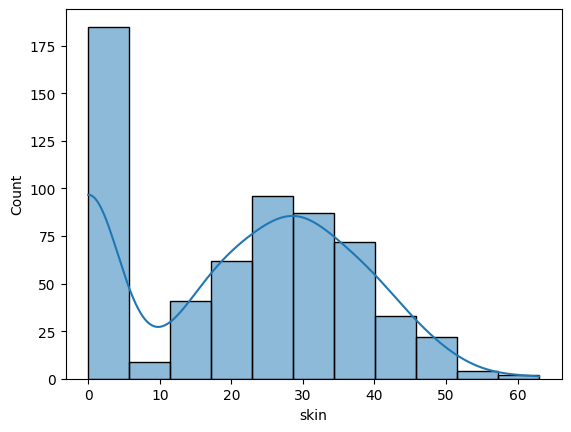

In [17]:
# skin
sns.histplot(train_set['skin'], kde=True)
plt.show()

In [18]:
bins_skin = [0, 10, 20, 30, 40, 50, np.inf] 
labels_skin = ["0-10", "10-20", "20-30", "30-40", "40-50", "50+"]

train_set['skin'] = pd.cut(train_set['skin'], bins=bins_skin, labels=labels_skin, right=False)
train_set.sample()

,preg,plas,pres,skin,test,mass,pedi,age,class
573,1-2,143,80-90,30-40,330,30.1,0.892,23,0


c:\Users\lucas\Documents\Cursos\The_Bridge\BOOTCAMP\Online_env\ONLINE_DS_THEBRIDGE_BOOTCAMP\04_Machine_Learning\Sprint_11\Unidad_02_Boosting_y_Bagging\Practica_Obligatoria\bootcampviztools.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_data = df.groupby([cat_col1, cat_col2]).size().reset_index(name='count')


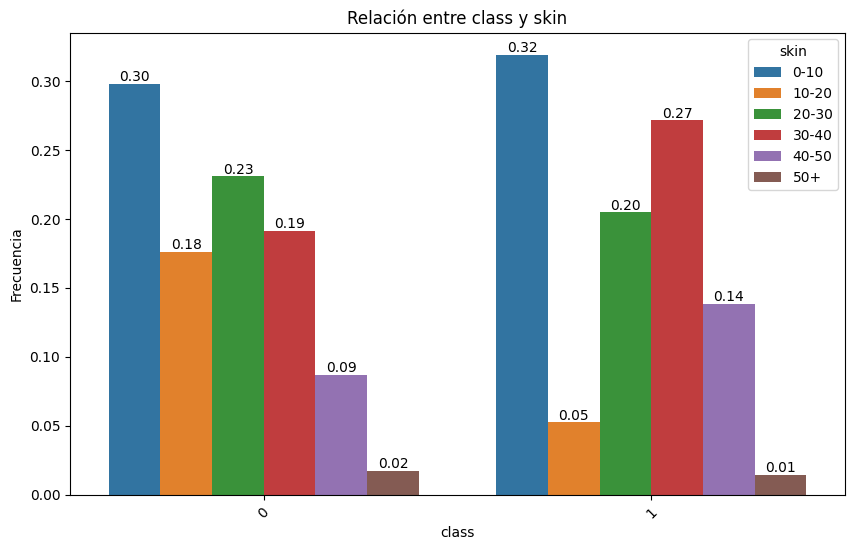

In [19]:
bt.plot_categorical_relationship_fin(train_set, target,"skin", show_values= True, relative_freq= True)

La incidencia de cada categoría parece ser diferente para el target, de tal manera que la columna será considerada relevante y se mantendrá para el modelo.

c:\Users\lucas\anaconda3\envs\GPU-TensorFlow\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


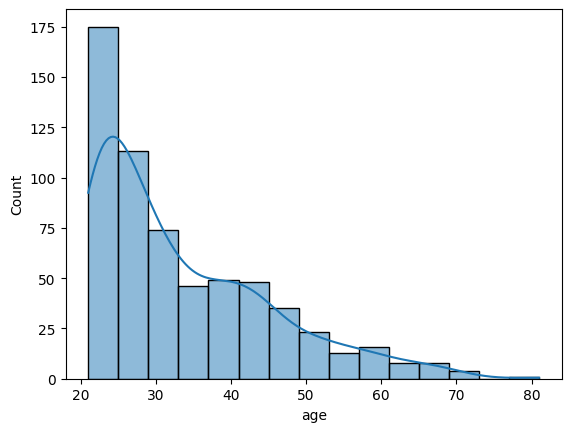

In [20]:
# age
sns.histplot(train_set['age'], kde=True)
plt.show()

In [21]:
bins_age = [0, 25, 35, 45, 60, np.inf] 
labels_age = ["0-25", "25-35", "35-45", "45-60","60+"]

train_set['age'] = pd.cut(train_set['age'], bins=bins_age, labels=labels_age, right=False)
train_set.sample()

,preg,plas,pres,skin,test,mass,pedi,age,class
171,2-5,87,0-20,20-30,0,28.9,0.773,25-35,0


c:\Users\lucas\Documents\Cursos\The_Bridge\BOOTCAMP\Online_env\ONLINE_DS_THEBRIDGE_BOOTCAMP\04_Machine_Learning\Sprint_11\Unidad_02_Boosting_y_Bagging\Practica_Obligatoria\bootcampviztools.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_data = df.groupby([cat_col1, cat_col2]).size().reset_index(name='count')


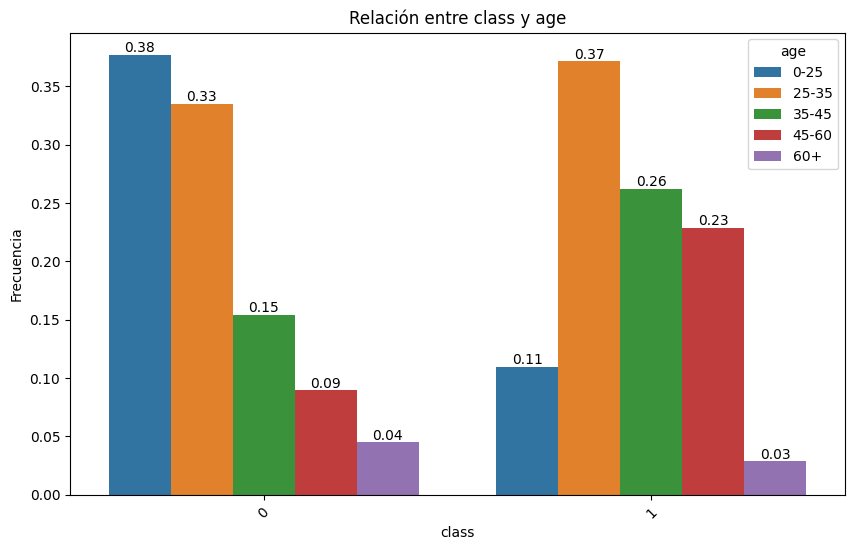

In [22]:
bt.plot_categorical_relationship_fin(train_set, target,"age", show_values= True, relative_freq= True)

La incidencia de cada categoría parece ser diferente para el target, de tal manera que la columna será considerada relevante y se mantendrá para el modelo.

Escalonando com OrdinalEncoder

In [23]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder_preg = OrdinalEncoder(categories=[labels_preg])
ordinal_encoder_pres = OrdinalEncoder(categories=[labels_pres])
ordinal_encoder_skin = OrdinalEncoder(categories=[labels_skin])
ordinal_encoder_age = OrdinalEncoder(categories=[labels_age])

train_set['preg_encoded'] = ordinal_encoder_preg.fit_transform(train_set[['preg']])
train_set['pres_encoded'] = ordinal_encoder_pres.fit_transform(train_set[['pres']])
train_set['skin_encoded'] = ordinal_encoder_skin.fit_transform(train_set[['skin']])
train_set['age_encoded'] = ordinal_encoder_age.fit_transform(train_set[['age']])

Variables NUMÉRICAS

In [ ]:
# Acordate de trazar la matriz de correlación!!!!! Evitar multicolinealidade!!!!!!!

c:\Users\lucas\anaconda3\envs\GPU-TensorFlow\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


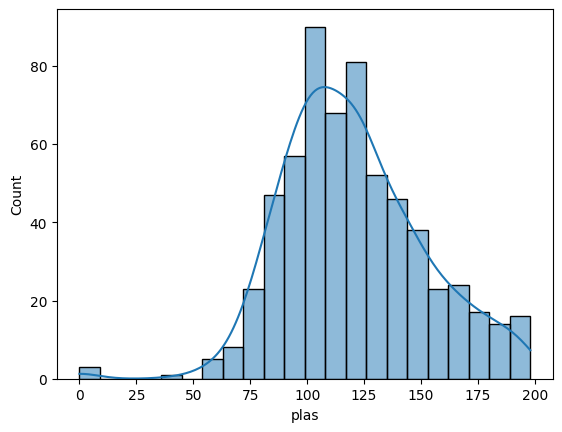

In [24]:
# plas

sns.histplot(train_set['plas'], kde=True)
plt.show()

Similar a gausiana

c:\Users\lucas\anaconda3\envs\GPU-TensorFlow\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


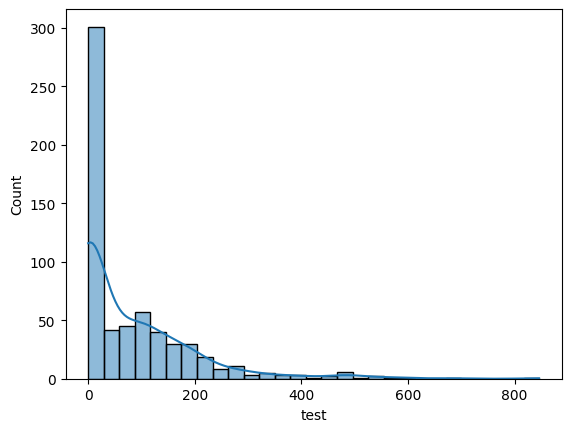

In [25]:
# test
sns.histplot(train_set['test'], kde=True)
plt.show()

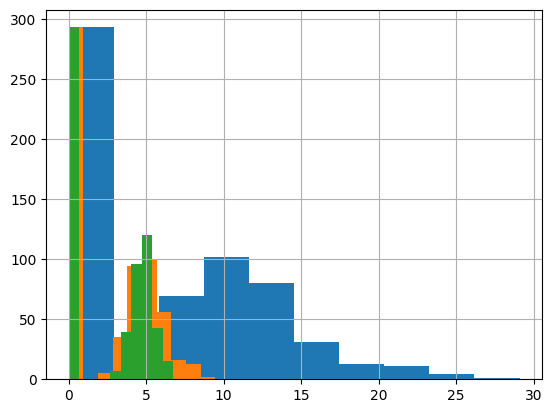

In [26]:
np.sqrt(train_set["test"]).hist() 
np.cbrt(train_set["test"]).hist() 
np.log(train_set["test"] + 1).hist() 
plt.show()

In [27]:
# Transformando con raíz cuadrada
train_set["test"] = train_set["test"].apply(np.sqrt)

c:\Users\lucas\anaconda3\envs\GPU-TensorFlow\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


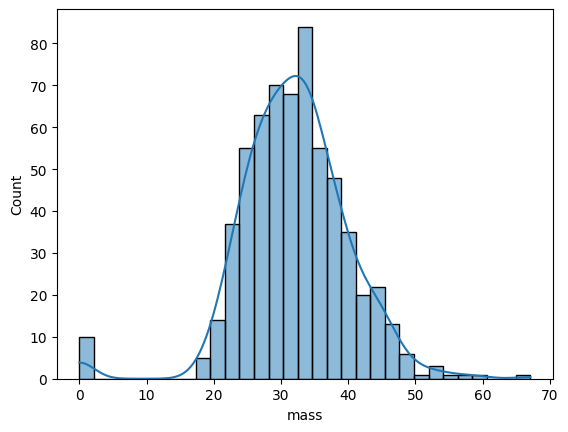

In [28]:
# mass
sns.histplot(train_set['mass'], kde=True)
plt.show()

Similar a gausiana

c:\Users\lucas\anaconda3\envs\GPU-TensorFlow\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


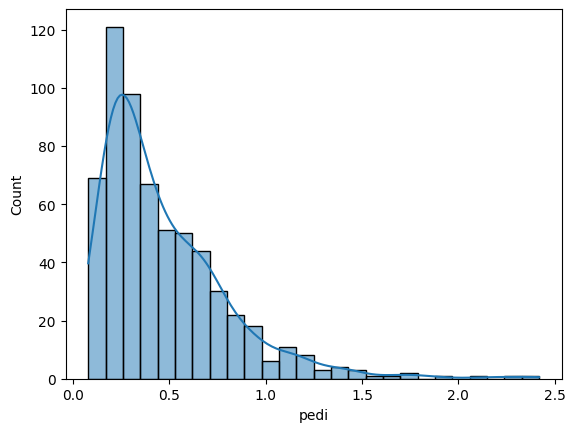

In [29]:
sns.histplot(train_set['pedi'], kde=True)
plt.show()

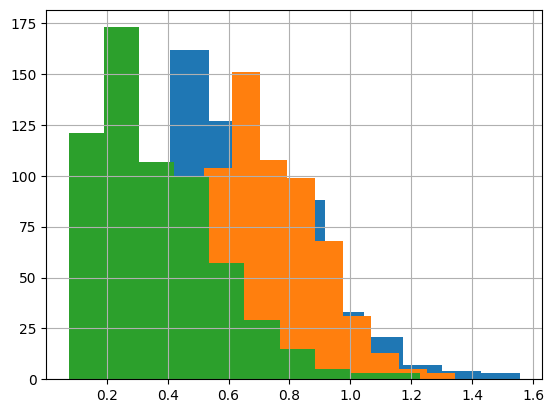

In [30]:
np.sqrt(train_set["pedi"]).hist() 
np.cbrt(train_set["pedi"]).hist() 
np.log(train_set["pedi"] + 1).hist() 
plt.show()

In [31]:
# Transformando con raíz cúbica
train_set["pedi"] = train_set["pedi"].apply(np.cbrt)

Escalonando com StandartScaler

In [32]:
scaler_num = StandardScaler()

In [33]:
train_set[features_num] = scaler_num.fit_transform(train_set[features_num])


Aplicando todas las transformaciones a test_set

In [34]:
# aplicando tudo ao teste

test_set['preg'] = pd.cut(test_set['preg'], bins=bins_preg, labels=labels_preg, right=False)
test_set['pres'] = pd.cut(test_set['pres'], bins=bins_pres, labels=labels_pres, right=False)
test_set['skin'] = pd.cut(test_set['skin'], bins=bins_skin, labels=labels_skin, right=False)
test_set['age'] = pd.cut(test_set['age'], bins=bins_age, labels=labels_age, right=False)

test_set['preg_encoded'] = ordinal_encoder_preg.transform(test_set[['preg']])
test_set['pres_encoded'] = ordinal_encoder_pres.transform(test_set[['pres']])
test_set['skin_encoded'] = ordinal_encoder_skin.transform(test_set[['skin']])
test_set['age_encoded'] = ordinal_encoder_age.transform(test_set[['age']])

test_set["test"] = test_set["test"].apply(np.sqrt)
test_set["pedi"] = test_set["pedi"].apply(np.cbrt)

test_set[features_num] = scaler_num.fit_transform(test_set[features_num])

In [35]:
features_num = ["plas", "test", "mass", "pedi"]
features_cat = ["preg_encoded", "pres_encoded", "skin_encoded", "age_encoded"]
features = features_num + features_cat

## Clasificación

In [36]:
X_train = train_set[features]
y_train = train_set[target]
X_test = test_set[features]
y_test = test_set[target]

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

model_names = ["Logistic Regression","DecisionTree","Random Forest","XGBoost","LightGBM","CatBoost"]
lr_clf = LogisticRegression(max_iter = 10000)
tree_clf = DecisionTreeClassifier(random_state= 42)
rf_clf = RandomForestClassifier(random_state= 42)
xgb_clf = XGBClassifier(random_state = 42)
lgb_clf = LGBMClassifier(random_state= 42, verbose = -100)
cat_clf = CatBoostClassifier(random_state= 42, verbose = False)

model_set = [lr_clf, tree_clf, rf_clf, xgb_clf, lgb_clf, cat_clf]


In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

results = {}

for nombre, modelo in zip(model_names, model_set):
    modelo.fit(X_train, y_train)
    
    y_train_pred = modelo.predict(X_train)
    
    accuracy = accuracy_score(y_train, y_train_pred)
    precision = precision_score(y_train, y_train_pred)
    recall = recall_score(y_train, y_train_pred)
    
    cm = confusion_matrix(y_train, y_train_pred)

    print(f"{nombre} - Accuracy: {accuracy:.4f}")
    print(f"{nombre} - Precision: {precision:.4f}")
    print(f"{nombre} - Recall: {recall:.4f}")

    print(f"Confusion Matrix:\n{cm}\n")

Logistic Regression - Accuracy: 0.7651
Logistic Regression - Precision: 0.7063
Logistic Regression - Recall: 0.5381
Confusion Matrix:
[[356  47]
 [ 97 113]]

DecisionTree - Accuracy: 1.0000
DecisionTree - Precision: 1.0000
DecisionTree - Recall: 1.0000
Confusion Matrix:
[[403   0]
 [  0 210]]

Random Forest - Accuracy: 1.0000
Random Forest - Precision: 1.0000
Random Forest - Recall: 1.0000
Confusion Matrix:
[[403   0]
 [  0 210]]

XGBoost - Accuracy: 1.0000
XGBoost - Precision: 1.0000
XGBoost - Recall: 1.0000
Confusion Matrix:
[[403   0]
 [  0 210]]

LightGBM - Accuracy: 1.0000
LightGBM - Precision: 1.0000
LightGBM - Recall: 1.0000
Confusion Matrix:
[[403   0]
 [  0 210]]

CatBoost - Accuracy: 0.9608
CatBoost - Precision: 0.9895
CatBoost - Recall: 0.8952
Confusion Matrix:
[[401   2]
 [ 22 188]]



Overfitting extremo en casi todos los modelos ensamblados.

Buscando reducir el Overfiting con GridSearch y tocando los hiperparámetros

#### RandomForest


In [ ]:
params_grid = {
    "n_estimators": [100,200,400],
    "max_depth": [2,4,10],
    "min_samples_leaf": [2, 5, 10,20,40],
    "max_features": ["sqrt","log2",None],
    "max_samples": [0.3,0.6,1]
}

rf_grid = GridSearchCV(rf_clf,
                       param_grid= params_grid,
                       cv = 5,
                       scoring = "recall",
                       n_jobs = -1)

rf_grid.fit(X_train, y_train)

c:\Users\lucas\anaconda3\envs\GPU-TensorFlow\lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [2, 4, 10],
                         'max_features': ['sqrt', 'log2', None],
                         'max_samples': [0.3, 0.6, 1],
                         'min_samples_leaf': [2, 5, 10, 20, 40],
                         'n_estimators': [100, 200, 400]},
             scoring='recall')

In [44]:
print(rf_grid.best_params_)
print("best_score", rf_grid.best_score_)

{'max_depth': 2, 'max_features': None, 'max_samples': 0.3, 'min_samples_leaf': 40, 'n_estimators': 100}
best_score 0.6047619047619047


              precision    recall  f1-score   support

           0       0.80      0.80      0.80       403
           1       0.61      0.61      0.61       210

    accuracy                           0.74       613
   macro avg       0.71      0.71      0.71       613
weighted avg       0.74      0.74      0.74       613



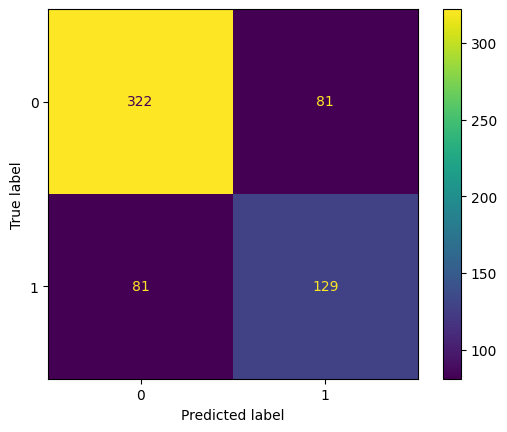

In [45]:
y_pred_rf = rf_grid.best_estimator_.predict(X_train)
print(classification_report(y_train, y_pred_rf))
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_rf)
plt.show()

In [ ]:
# Acordate de mirar las feature_importances_ de llos modelos entrenados

              precision    recall  f1-score   support

           0       0.81      0.85      0.83        97
           1       0.72      0.67      0.69        57

    accuracy                           0.78       154
   macro avg       0.76      0.76      0.76       154
weighted avg       0.78      0.78      0.78       154



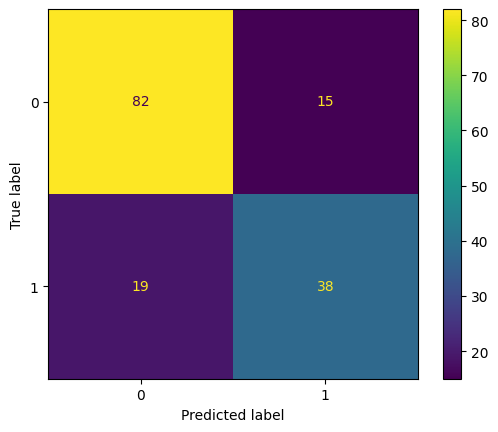

In [47]:
y_pred_test_rf = rf_grid.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred_test_rf))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_rf)
plt.show()

#### XGBoost

In [72]:
# Defina o grid de parâmetros
xgb_params_grid = {
    "n_estimators": [100, 200, 400],
    "max_depth": [2, 4, 10],
    "min_child_weight": [2, 5, 10],  
    "colsample_bytree": [0.3, 0.6, 1], 
    "subsample": [0.3, 0.6, 1] 
}

# Inicialize o XGBClassifier
xgb_clf = XGBClassifier()

# Configurando o GridSearchCV
xgb_clf_grid = GridSearchCV(estimator=xgb_clf,
                            param_grid=xgb_params_grid,
                            cv=5,
                            scoring="recall",
                            n_jobs=-1)

# Ajustando o modelo aos dados de treino
xgb_clf_grid.fit(X_train, y_train)

c:\Users\lucas\anaconda3\envs\GPU-TensorFlow\lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.3, 0.6, 1],
                         'max_depth': [2, 4, 10],
                         'min_child_weight': [2, 5, 10],
                         'n_estimators': [100, 200, 400],
                         'subsample': [0.3, 0.6, 1]},
             scoring='recall')

In [73]:
print(xgb_clf_grid.best_params_)
print("best_score", xgb_clf_grid.best_score_)

{'colsample_bytree': 1, 'max_depth': 2, 'min_child_weight': 10, 'n_estimators': 100, 'subsample': 0.6}
best_score 0.6238095238095238


              precision    recall  f1-score   support

           0       0.87      0.92      0.90       403
           1       0.83      0.73      0.78       210

    accuracy                           0.86       613
   macro avg       0.85      0.83      0.84       613
weighted avg       0.86      0.86      0.86       613



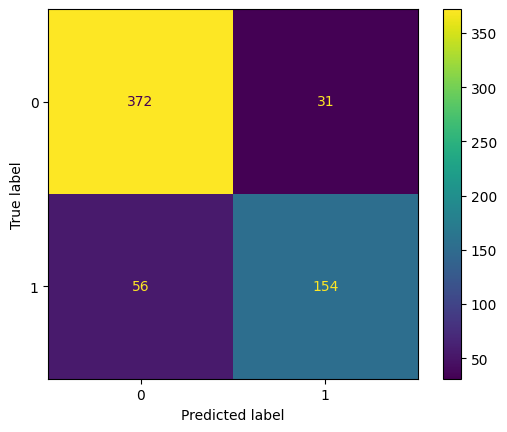

In [74]:
y_pred_xgb = xgb_clf_grid.best_estimator_.predict(X_train)
print(classification_report(y_train, y_pred_xgb))
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_xgb)
plt.show()

              precision    recall  f1-score   support

           0       0.78      0.80      0.79        97
           1       0.65      0.61      0.63        57

    accuracy                           0.73       154
   macro avg       0.71      0.71      0.71       154
weighted avg       0.73      0.73      0.73       154



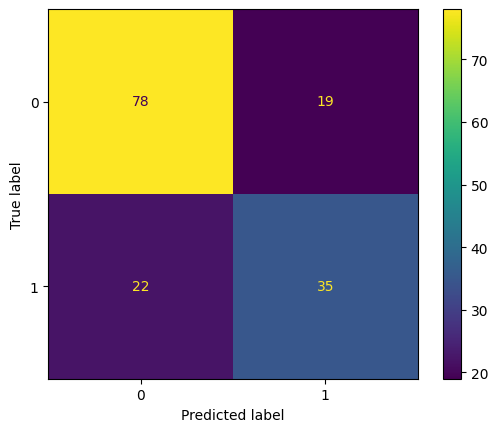

In [75]:
y_pred_test_xgb = xgb_clf_grid.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred_test_xgb))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_xgb)
plt.show()

#### LGBM

In [61]:
lgb_params_grid = {
    "n_estimators": [100, 200, 400],
    "max_depth": [2, 4, 10],
    "min_child_samples": [10, 20, 50],
    "num_leaves": [15, 31, 63],
    "subsample": [0.6, 0.8, 1],
    "learning_rate": [0.01, 0.1, 0.3],  
}

lgb_clf = LGBMClassifier(random_state=42, verbose=-100)

lgb_grid_search = GridSearchCV(estimator=lgb_clf, 
                               param_grid=lgb_params_grid, 
                               cv=5, 
                               scoring='recall', 
                               n_jobs=-1)

lgb_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=42, verbose=-100),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [2, 4, 10],
                         'min_child_samples': [10, 20, 50],
                         'n_estimators': [100, 200, 400],
                         'num_leaves': [15, 31, 63],
                         'subsample': [0.6, 0.8, 1]},
             scoring='recall')

In [64]:
print(lgb_grid_search.best_params_)
print("best_score", lgb_grid_search.best_score_)

{'learning_rate': 0.1, 'max_depth': 2, 'min_child_samples': 10, 'n_estimators': 400, 'num_leaves': 15, 'subsample': 0.6}
best_score 0.6


              precision    recall  f1-score   support

           0       0.94      0.97      0.95       403
           1       0.94      0.87      0.91       210

    accuracy                           0.94       613
   macro avg       0.94      0.92      0.93       613
weighted avg       0.94      0.94      0.94       613



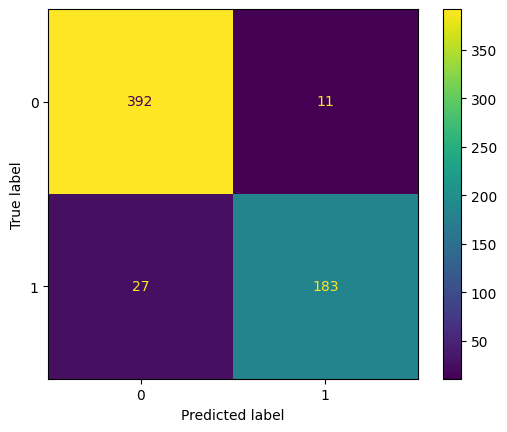

In [65]:
y_pred_lgb = lgb_grid_search.best_estimator_.predict(X_train)
print(classification_report(y_train, y_pred_lgb))
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_lgb)
plt.show()

              precision    recall  f1-score   support

           0       0.78      0.82      0.80        97
           1       0.67      0.60      0.63        57

    accuracy                           0.74       154
   macro avg       0.72      0.71      0.71       154
weighted avg       0.74      0.74      0.74       154



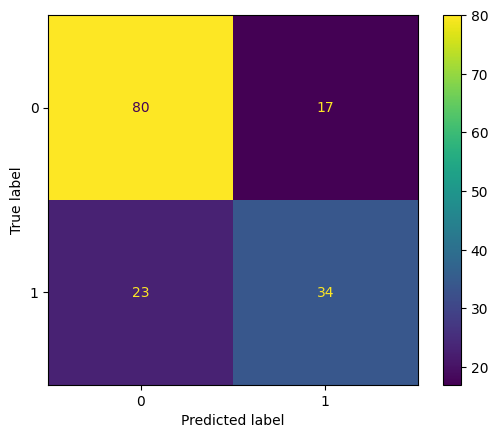

In [66]:
y_pred_test_lgb = lgb_grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred_test_lgb))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_lgb)
plt.show()

## Modelo Elegido

In [78]:
print(rf_grid.best_estimator_)

RandomForestClassifier(max_depth=2, max_features=None, max_samples=0.3,
                       min_samples_leaf=40, random_state=42)
